In [5]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import END, START
from langgraph.graph.state import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode
from langchain_core.tools import tool
from langchain_core.messages import BaseMessage
import os
from dotenv import load_dotenv
load_dotenv()

True

In [31]:
os.environ["LANGSMITH_PROJECT"]="TestProject"

In [2]:
import os
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
os.environ["LANGSMITH_API_KEY"]=os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGSMITH_TRACING"]="true"


In [3]:
from langchain.chat_models import init_chat_model
llm=init_chat_model("groq:llama3-8b-8192")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000001818A5238C0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000001818A6C4590>, model_name='llama3-8b-8192', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [6]:
class State(TypedDict):
    messages:Annotated[list[BaseMessage],add_messages]

In [32]:
## Graph With tool Call
from langchain_core.tools import tool

@tool
def add(a:float,b:float):
    """Add two number"""
    return a+b
tools=[add]
tool_node=ToolNode([add])

llm_with_tool=llm.bind_tools([add])

def call_llm_model(state:State):
    return {"messages":[llm_with_tool.invoke(state['messages'])]}


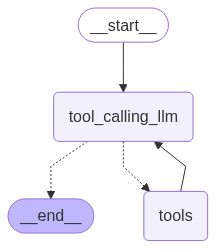

In [33]:
## Stategraph
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

## Node definition
def call_llm_model(state:State):
    return {"messages":[llm_with_tool.invoke(state['messages'])]}
## Grpah
builder=StateGraph(State)
builder.add_node("tool_calling_llm",call_llm_model)
builder.add_node("tools",ToolNode(tools))

## Add Edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition
)
builder.add_edge("tools","tool_calling_llm")

## compile the graph
graph=builder.compile()

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [35]:
response=graph.invoke({"messages":"What is machine learning"})

In [36]:
response

{'messages': [HumanMessage(content='What is machine learning', additional_kwargs={}, response_metadata={}, id='7572b892-93e5-463e-bee5-416017c30bb6'),
  AIMessage(content='Machine learning is a type of artificial intelligence (AI) that enables computers to learn from data without being explicitly programmed. It involves training algorithms on large datasets to identify patterns, make predictions, and improve their performance over time.\n\nMachine learning is a subfield of artificial intelligence that focuses on developing algorithms and statistical models that enable machines to learn from data and make decisions. The goal of machine learning is to enable machines to automatically improve their performance on a task without being explicitly programmed.\n\nMachine learning can be used for a wide range of applications, including image and speech recognition, natural language processing, recommender systems, and autonomous vehicles. It is also used in many industries, such as healthcare,

In [37]:
response=graph.invoke({"messages":"what is 5 plus 20"})

In [30]:
response

{'messages': [HumanMessage(content='what is 5 plus 20', additional_kwargs={}, response_metadata={}, id='c50b70a3-e924-4f68-a13c-f3739e632b7e'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'nc8a5spm9', 'function': {'arguments': '{"a":5,"b":20}', 'name': 'add'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 72, 'prompt_tokens': 898, 'total_tokens': 970, 'completion_time': 0.144936166, 'prompt_time': 0.368290252, 'queue_time': 0.483140518, 'total_time': 0.513226418}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_8af39bf2ae', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--fe10d726-9c8a-4da7-a787-7415e932ef55-0', tool_calls=[{'name': 'add', 'args': {'a': 5, 'b': 20}, 'id': 'nc8a5spm9', 'type': 'tool_call'}], usage_metadata={'input_tokens': 898, 'output_tokens': 72, 'total_tokens': 970}),
  ToolMessage(content='25.0', name='add', id='8f478294-cabc-4c7d-aa61-51e493966247', tool_call_id='nc8a5spm9'),
  AIMessage(cont